# Prepare novel images to be annoateted (HeLa dataset):
## 1 - Loading the images without labels:

[INFO] The demo folder contain :  84  images


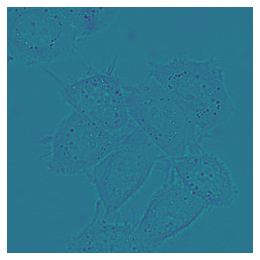

100%|██████████| 84/84 [00:01<00:00, 42.20it/s]


In [1]:
import sys
sys.path.append('../')

from torch.utils.data import DataLoader
from utils import CustomDataset
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob
from PIL import Image
from tqdm import tqdm
import os

# Path to the dataset images
main_dir = os.path.join('..', '..',  'dataset', 'hela_cells_dataset')

# Path to the novel images -wthout annotations- ex. 01 folder
demo_dir = os.path.join(main_dir, 'DIC-C2DH-HeLa', '02')

# Path to the reference image (for normalization)
ref_image_path = os.path.join('..', '..', 'dataset','augmented_hela_cells_dataset', 'train', '5_img.tif')

# Loading the paths on all images in the demo dir
demo_imgs_paths = natsorted(glob(os.path.join(demo_dir, '*.tif')))

# Showing basic infromation about the images
print('[INFO] The demo folder contain : ',len(demo_imgs_paths),' images')

# Showing an example from the demo folder
plt.imshow(Image.open(demo_imgs_paths[0]))
plt.tight_layout()
plt.axis('off')
plt.show()

# Path where to store the annotations
novel_annotation = os.path.join(main_dir, 'novel_annotation')

# Path to store a copy of the images
img_annot_dir = os.path.join(novel_annotation, 'images')

# Create a foledr if there isn't one
os.makedirs(img_annot_dir, exist_ok = True)

for i in range(len(demo_imgs_paths)):
    tmp_img = Image.open(demo_imgs_paths[i])
    tmp_img.save(os.path.join(img_annot_dir, str(i)+'.tif'))

# Number of the workers (CPUs) to be used by the dataloader (HDD -> RAM -> GPU)
n_workers = 4

# Make this true if you have alot of RAM to store all the training dataset in RAM
# (This will speed up the training at the coast of huge RAM consumption)
pin_memory = True

################# U-NET parameters ####################################
# The number of input images    (RGB       ->  n_input_channels=3)
#                               (Gray      ->  n_input_channels=1)
n_input_channels = 1

# The number of output classes  (N classs  ->  n_output_channels = N)
n_output_channels = 1

# Since the model was trained on 512x512 images we don't need to resize
scale_factor = 1
#######################################################################

# Preparing the demo images and load then using the dataloader
demo_dataset = CustomDataset(demo_imgs_paths, [], ref_image_path, normalize=True,cached_data=pin_memory, n_channels=n_input_channels, scale=scale_factor)
demo_loader = DataLoader(demo_dataset, batch_size=1, shuffle=False, pin_memory=pin_memory, num_workers=n_workers)


## 2 - Cell masks prediction:
### 2.a - Binary mask predictor:

In [2]:
import torch
from unet import UNet
import numpy as np

# The path to the best epoch based on Cross-validation (best test result)
path_bn_mask_ckpts = os.path.join('..', 'experiments', 'norm_5_cross-val_binary_mask_unet_EP_5_ES_10_BS_1_LR_0.0001_RS_2022')
path_bn_mask_ckpts = os.path.join(path_bn_mask_ckpts, 'ckpts', 'FOLD-3', 'best_model.pth')

# Path to store the predicted masks
bn_mask_annot_dir = os.path.join(novel_annotation, 'binary_masks')

# Create a foledr if there isn't one
os.makedirs(bn_mask_annot_dir, exist_ok = True)

################# Computation hyper parameters ########################
# Chose the GPU cuda device to make the inference go much faster vs CPU use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Using one GPU (available)
if torch.cuda.is_available():
    # For faster convolutions, but more memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
#######################################################################

# Binary mask threshold (binary mask generation after sigmoid)
eval_threshold = 0.05

# defining the U-Net model
model = UNet(n_channels=n_input_channels, n_classes=n_output_channels)

# Putting the model inside the device
model.to(device=device)

# Load the best model
model.load_state_dict(torch.load(path_bn_mask_ckpts, map_location=device))

# Putting the model in evluation mode (no gradients are needed)
model.eval()

# Global counter
count = 0
for batch in tqdm(demo_loader):
    # Load the image and mask
    image = batch['image']

    # Make sure the data loader did prepare images properly
    assert image.shape[1] == n_input_channels, \
        f'The input image size {image.shape[1]} ' \
        f', yet the model have {n_input_channels} input channels'

    # Load the image into device memory
    image = image.to(device=device, dtype=torch.float32)

    # No need to use the gradients (no backward passes -evaluation only-)
    with torch.no_grad():

        # Computing the prediction on the input image
        pred_mask = model(image)

        # Applying the sigmoid function to ensure values betwenn 0 and 1
        pred_mask = torch.sigmoid(pred_mask)

        # Getting the predected mask
        np_pred = np.array(pred_mask.cpu())

        # Converting from numpy to PIL image
        pil_img = Image.fromarray(np_pred[0][0]> eval_threshold) # > eval_threshold

        # Save the mask
        pil_img.save(os.path.join(bn_mask_annot_dir, str(count)+'.tif'))
        count += 1


100%|██████████| 84/84 [00:16<00:00,  5.10it/s]


### 2.b - Intra-cellular cell mask predictor:

In [3]:
import torch
from unet import UNet
import numpy as np

# The path to the best epoch based on Cross-validation (best test result)
path_bn_mask_ckpts = os.path.join('..', 'experiments', 'norm_5_cross-val_density_mask_unet_EP_5_ES_10_BS_1_LR_0.0001_RS_2022')
path_bn_mask_ckpts = os.path.join(path_bn_mask_ckpts, 'ckpts', 'FOLD-3', 'best_model.pth')

# Path to store the predicted masks
bn_mask_annot_dir = os.path.join(novel_annotation, 'density_masks')

# Create a foledr if there isn't one
os.makedirs(bn_mask_annot_dir, exist_ok = True)

################# Computation hyper parameters ########################
# Chose the GPU cuda device to make the inference go much faster vs CPU use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Using one GPU (available)
if torch.cuda.is_available():
    # For faster convolutions, but more memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
#######################################################################

# Binary mask threshold (binary mask generation after sigmoid)
eval_threshold = 0.5

# defining the U-Net model
model = UNet(n_channels=n_input_channels, n_classes=n_output_channels)

# Putting the model inside the device
model.to(device=device)

# Load the best model
model.load_state_dict(torch.load(path_bn_mask_ckpts, map_location=device))

# Putting the model in evluation mode (no gradients are needed)
model.eval()

# Global counter
count = 0
for batch in tqdm(demo_loader):
    # Load the image and mask
    image = batch['image']

    # Make sure the data loader did prepare images properly
    assert image.shape[1] == n_input_channels, \
        f'The input image size {image.shape[1]} ' \
        f', yet the model have {n_input_channels} input channels'

    # Load the image into device memory
    image = image.to(device=device, dtype=torch.float32)

    # No need to use the gradients (no backward passes -evaluation only-)
    with torch.no_grad():

        # Computing the prediction on the input image
        pred_mask = model(image)

        # Applying the sigmoid function to ensure values betwenn 0 and 1
        pred_mask = torch.sigmoid(pred_mask)

        # Getting the predected mask
        np_pred = np.array(pred_mask.cpu())

        # Converting from numpy to PIL image
        pil_img = Image.fromarray(np_pred[0][0]) #> eval_threshold

        # Save the mask
        pil_img.save(os.path.join(bn_mask_annot_dir, str(count)+'.tif'))
        count += 1


100%|██████████| 84/84 [00:09<00:00,  8.44it/s]
